IMPORTING THE LIBRARIES

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import pyfpgrowth
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, fpmax, fpgrowth

c:\Users\aashi\anaconda3\lib\site-packages\scipy\fft\__init__.py:97: DeprecationWarning: The module numpy.dual is deprecated.  Instead of using dual, use the functions directly from numpy or scipy.
  from numpy.dual import register_func
c:\Users\aashi\anaconda3\lib\site-packages\scipy\sparse\sputils.py:17: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  supported_dtypes = [np.typeDict[x] for x in supported_dtypes]
c:\Users\aashi\anaconda3\lib\site-packages\scipy\sparse\sputils.py:17: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  supported_dtypes = [np.typeDict[x] for x in supported_dtypes]
c:\Users\aashi\anaconda3\lib\site-packages\scipy\sparse\sputils.py:17: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  supported_dtypes = [np.typeDict[x] for x in supported_dtypes]
c:\Users\aashi\anaconda3\lib\site-packages\scipy\sparse\sputils.py:17: DeprecationWarning: `np.typeDict` is a deprecated alias 

LOADING AND PREPROCESSING THE DATA

In [2]:
# Path to your Excel file
# file_path = 'C:\\Users\\aashi\\Desktop\\GA Tech docs\\Seventh Sem Spring 24\\ISYE 7406 - Data Mining and Statistical Learning\\Project\\Our project\\data\\Amazon_ 2_Raw.xlsx'

file_path = './data/Amazon_2_Raw.xlsx'

# Read the Excel file into a DataFrame
df = pd.read_excel(file_path, sheet_name='Amazon')

# product id to name dictionary 

product_id_to_name = dict(zip(df['Product_ID'], df['Product Name']))

# Display the DataFrame
print(df.head())

# Check for missing values
missing_values = df.isnull().sum()
print("Missing Values:")
# print(missing_values)

# Check for duplicate rows
duplicate_rows = df.duplicated().sum()
# print("Duplicate Rows:", duplicate_rows)

# Check datatype of each column
data_types = df.dtypes
print(data_types)

# Calculate unit price for each transaction
df['Unit Price'] = df['Sales'] / df['Quantity']

         Order ID Order Date  Ship Date   Customer Name        Country  \
0  CA-2013-138688 2013-06-13 2013-06-17   DarrinVanHuff  United States   
1  CA-2011-115812 2011-06-09 2011-06-14  BrosinaHoffman  United States   
2  CA-2011-115812 2011-06-09 2011-06-14  BrosinaHoffman  United States   
3  CA-2011-115812 2011-06-09 2011-06-14  BrosinaHoffman  United States   
4  CA-2011-115812 2011-06-09 2011-06-14  BrosinaHoffman  United States   

          City       State     Category Product_ID  \
0  Los Angeles  California       Labels  AMZ_P_001   
1  Los Angeles  California  Furnishings  AMZ_P_002   
2  Los Angeles  California          Art  AMZ_P_003   
3  Los Angeles  California       Phones  AMZ_P_004   
4  Los Angeles  California      Binders  AMZ_P_005   

                                        Product Name    Sales  Quantity  \
0  Self-Adhesive Address Labels for Typewriters b...   14.620         2   
1  Eldon Expressions Wood and Plastic Desk Access...   48.860         7   
2    

PERFORMING RFM 

AGGREGATING DATA AT CUSTOMER LEVEL: We consolidate the data on a per-customer basis to examine the purchasing patterns of individual customers.

In [3]:
## JB0327
df['Order Date'].max()

Timestamp('2014-12-31 00:00:00')

In [4]:
# Aggregate data by Customer Name
customer_data = df.groupby('Customer Name').agg({
    'Order Date': lambda x: (x.max() - x.min()).days,
    'Order ID': 'count',
    'Sales': 'sum',
    'Profit': 'sum'
}).rename(columns={'Order Date': 'Recency', 'Order ID': 'Frequency', 'Sales': 'TotalSpend'})

customer_data.head()

,Recency,Frequency,TotalSpend,Profit
Customer Name,,,,
AaronBergman,0,3,309.592,15.0033
AaronHawkins,594,5,1328.124,179.8842
AaronSmayling,373,3,737.028,19.1547
AdamBellavance,780,5,2693.918,363.7782
AdamHart,882,5,463.770,99.2752


In [5]:
## JB0327
def create_quantiles(rfm_file):
    
    """ Function to Create RQM Ranking """
    
    # Add Quantiles Frequency
    quartiles_qty               = rfm_file['Frequency'].drop_duplicates().quantile([.20, .40, .60, 0.80]).tolist()
    quartiles_qty               = [0] + quartiles_qty + [float('inf')]
    
    try:
        rfm_file['Rel_Frequency']   = pd.cut(rfm_file['Frequency'], 
                                             bins=quartiles_qty, 
                                             labels=['1', '2', '3', '4', '5'],
                                             include_lowest=True)
    except:
        rfm_file['Rel_Frequency']   = '2'
    
    # Add Quantiles Monetary Value
    quartiles_price               = rfm_file['TotalSpend'].drop_duplicates().quantile([.20, .40, .60, 0.80]).tolist()
    quartiles_price               = [0] + quartiles_price + [float('inf')]
    
    try:
        rfm_file['Rel_TotalSpend']   = pd.cut(rfm_file['TotalSpend'], 
                                               bins=quartiles_price, 
                                               labels=['1', '2', '3', '4', '5'],
                                               include_lowest=True)
    except:
        rfm_file['Rel_TotalSpend']   = '2'
    
    # Add Quantiles Recency
    quartiles_recency             = rfm_file['Recency'].drop_duplicates().quantile([.20, .40, .60, 0.80]).tolist()
    quartiles_recency             = [0] + quartiles_recency + [float('inf')]
    
    try:
        rfm_file['Rel_Recency'] = pd.cut(rfm_file['Recency'], 
                                               bins=quartiles_recency, 
                                               labels=['5', '4', '3', '2', '1'],
                                               include_lowest=True)
    except:
        rfm_file['Rel_Recency']   = '2'
    
    ## Summing the rqm scores 
    rfm_file['Rqm_Score']         = rfm_file['Rel_Frequency'].astype(int) + \
                                    rfm_file['Rel_TotalSpend'].astype(int) +\
                                    rfm_file['Rel_Recency'].astype(int)
    # Rank the distribution
    rfm_file['Rank']              = rfm_file['Rqm_Score'].rank(ascending=False, method='first')
    
    # Sort Data by Rank
    rfm_file = rfm_file.sort_values(by='Rank', ascending=True).astype({'Rank':int})
    
    return rfm_file

In [6]:
## JB0327
customer_data_ranked = create_quantiles(customer_data)
customer_data_ranked.head()

,Recency,Frequency,TotalSpend,Profit,Rel_Frequency,Rel_TotalSpend,Rel_Recency,Rqm_Score,Rank
Customer Name,,,,,,,,,
LaurelBeltran,250,14,2836.040,-471.3007,4,5,5,14,1
SandraGlassco,46,10,2567.151,352.1862,3,5,5,13,2
AlanDominguez,98,5,4353.340,1535.8919,2,5,5,12,3
AlanSchoenberger,371,9,2017.184,262.2209,3,5,4,12,4
ArthurGainer,523,9,2382.179,169.9962,3,5,4,12,5


APPLYING THE ELBOW METHOD : To determine the optimal number of clusters for KMeans, we use the Elbow Method

c:\Users\aashi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  "KMeans is known to have a memory leak on Windows "


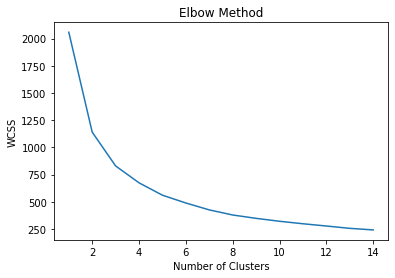

In [7]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Scale the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_data[['Recency', 'Frequency', 'TotalSpend']])

# Determine the optimal number of clusters using the Elbow Method
wcss = []
for i in range(1, 15):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)

# Plot the WCSS for each number of clusters
plt.plot(range(1, 15), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

IMPLEMENTING K-MEANS CLUSTERING  : With the optimal number of clusters determined i.e. 5, we apply the KMeans algorithm.

In [8]:
# Assuming optimal_clusters is determined from the Elbow plot
optimal_clusters = 5
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
customer_data['Segment'] = kmeans.fit_predict(scaled_features)

customer_data

,Recency,Frequency,TotalSpend,Profit,Rel_Frequency,Rel_TotalSpend,Rel_Recency,Rqm_Score,Rank,Segment
Customer Name,,,,,,,,,,
AaronBergman,0,3,309.592,15.0033,1,2,5,8,270.0,3
AaronHawkins,594,5,1328.124,179.8842,2,4,3,9,162.0,1
AaronSmayling,373,3,737.028,19.1547,1,3,4,8,271.0,3
AdamBellavance,780,5,2693.918,363.7782,2,5,2,9,163.0,0
AdamHart,882,5,463.770,99.2752,2,3,2,7,417.0,1
...,...,...,...,...,...,...,...,...,...,...
XylonaPreis,1100,12,660.190,298.3414,3,3,1,7,589.0,2
YanaSorensen,744,7,5754.172,1551.5945,2,5,3,10,159.0,4
YosephCarroll,147,2,1215.676,382.0575,1,4,5,10,160.0,3


ANALYZING THE SEGMENTS CHARACTERISTICS

In [9]:
cluster_analysis = customer_data.groupby('Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'TotalSpend': 'mean',
    'Profit': 'mean'
}).sort_values(by='Recency', ascending=True)

cluster_analysis


,Recency,Frequency,TotalSpend,Profit
Segment,,,,
3,63.346154,2.083916,365.144549,47.215362
0,370.690722,6.268041,2039.290629,243.336015
1,853.851852,4.502646,682.609463,103.821172
4,874.461538,9.230769,5620.287135,1169.878615
2,963.897727,10.318182,1682.666347,241.729731


From the presented output, it's evident that the KMeans clustering algorithm has partitioned the customer data into four discernible segments or clusters, taking into account factors such as Recency (the time elapsed since their last purchase), Frequency (the rate at which they make purchases), and TotalSpend (the cumulative amount they spend).

Cluster 3:

Recency: On average, customers in this segment made purchases approximately 63.35 days ago, indicating recent engagement with the store.
Frequency: The average number of transactions for customers in this cluster is 2.08, suggesting a moderate level of engagement.
TotalSpend: Customers in this cluster spend an average of $365.14 per transaction, indicating a moderate level of expenditure during their visits.
Profit: The average profit generated from customers in this cluster is $47.22, reflecting the net earnings from their transactions after accounting for costs.

Insights: Customers in this cluster are recent shoppers who make a low number of transactions and have a moderate total spend. While their engagement frequency is not very high, they contribute to a reasonable profit margin. This segment might include new or occasional shoppers who are still exploring the store's offerings.
Marketing Strategy:To encourage repeat visits and increase spending, consider implementing a first-time buyer or loyalty program, providing welcome discounts, or recommending popular products to increase their purchase frequency and amount.

Cluster 0:

Recency: On average, customers in this segment made purchases approximately 370.69 days ago, indicating less recent engagement with the store.
Frequency: The average number of transactions for customers in this cluster is 6.27, suggesting a relatively higher level of engagement compared to other clusters.
TotalSpend: Customers in this cluster spend an average of $2039.29 per transaction, indicating a higher level of expenditure during their visits.
Profit: The average profit generated from customers in this cluster is $243.34, reflecting the net earnings from their transactions after accounting for costs.

Insights: Customers in this cluster have made purchases relatively recently, with a moderate number of transactions and a high total spend. They are likely regular customers who make consistent purchases, contributing significantly to the store's revenue and profit margin.
Marketing Strategy:To maintain their loyalty and encourage continued spending, consider offering personalized recommendations based on their purchase history, providing special discounts for frequent shoppers, or launching targeted marketing campaigns to promote related products.

Cluster 1:

Recency: On average, customers in this segment made purchases approximately 853.85 days ago, indicating relatively less recent engagement with the store.
Frequency: The average number of transactions for customers in this cluster is 4.50, suggesting a moderate level of engagement.
TotalSpend: Customers in this cluster spend an average of $682.61 per transaction, indicating a moderate level of expenditure during their visits.
Profit: The average profit generated from customers in this cluster is $103.82, reflecting the net earnings from their transactions after accounting for costs.

Insights: Customers in this cluster have not made purchases recently, with a moderate frequency of transactions and a moderate total spend. This group may include occasional shoppers who haven't engaged with the store recently but have the potential to become more frequent customers.
Marketing Strategy:To re-engage this segment, consider sending personalized emails or notifications to remind them of their past purchases, offering limited-time discounts or promotions, or showcasing new products to encourage them to return.

Cluster 4:

Recency: On average, customers in this segment made purchases approximately 874.46 days ago, indicating less recent engagement with the store.
Frequency: The average number of transactions for customers in this cluster is 9.23, suggesting a higher level of engagement compared to other clusters.
TotalSpend: Customers in this cluster spend an average of $5620.29 per transaction, indicating a higher level of expenditure during their visits.
Profit: The average profit generated from customers in this cluster is $1169.88, reflecting the net earnings from their transactions after accounting for costs.

Insights: Customers in this cluster have made purchases recently, with a high frequency of transactions and the highest total spend. They are likely loyal customers who make frequent purchases and contribute significantly to revenue and profit margin.
Marketing Strategy:
To maintain and strengthen their loyalty, consider offering exclusive rewards or perks for VIP customers, providing early access to new products or sales events, or inviting them to participate in customer feedback programs to further tailor their shopping experience.

Cluster 2:

Recency: On average, customers in this segment made purchases approximately 963.90 days ago, indicating relatively less recent engagement with the store.
Frequency: The average number of transactions for customers in this cluster is 10.32, suggesting a higher level of engagement compared to other clusters.
TotalSpend: Customers in this cluster spend an average of $1682.67 per transaction, indicating a moderate level of expenditure during their visits.
Profit: The average profit generated from customers in this cluster is $241.73, reflecting the net earnings from their transactions after accounting for costs.

Insights: Customers in this cluster have not made purchases recently, but they have a high frequency of transactions and a moderate total spend. They might be dormant customers who were previously active but have since disengaged from the store.
Marketing Strategy: To reactivate this segment, consider sending targeted reactivation campaigns with incentives such as special discounts or bonuses, reaching out with personalized messages to remind them of their past purchases, or offering incentives for referring friends or family members.





RADAR CHART

c:\Users\aashi\anaconda3\lib\site-packages\matplotlib\projections\polar.py:723: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.array([[0.0, 0.0], [1.0, 1.0]], np.float),


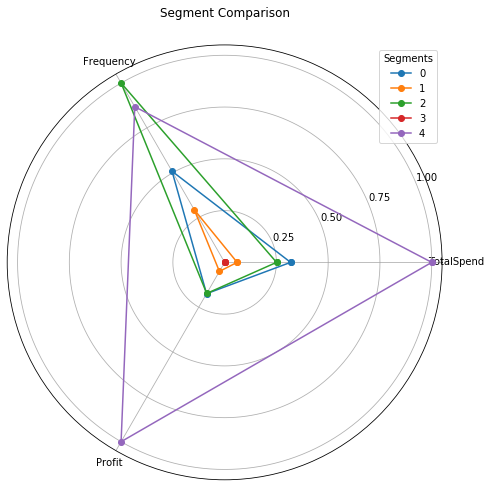

In [10]:
r_segment_stats = customer_data.groupby('Segment')[["TotalSpend", "Frequency", "Profit"]].mean()

# Normalize the data
segment_stats_normalized = (r_segment_stats - r_segment_stats.min()) / (r_segment_stats.max() - r_segment_stats.min())

# RADAR CHART
angles = np.linspace(0, 2 * np.pi, len(r_segment_stats.columns), endpoint=False).tolist()
angles += angles[:1]  # Close the plot
plt.figure(figsize=(8, 8))
for segment in segment_stats_normalized.index:
    values = segment_stats_normalized.loc[segment].tolist()
    values += values[:1]  # Close the plot
    plt.polar(angles, values, marker='o', label=segment)
plt.xticks(angles[:-1], r_segment_stats.columns)
plt.yticks([0.25, 0.5, 0.75, 1.0])
plt.title('Segment Comparison')
plt.legend(title='Segments')
plt.show()

PERFORMING LIFT, CONFIDENCE AND SUPPORT

CREATING LIST OF PRODUCTS BY ORDER ID

In [11]:
df.groupby(by='Order ID').agg({'Product_ID' : lambda x : list(set(x))})

,Product_ID
Order ID,
CA-2011-100090,"[AMZ_P_410, AMZ_P_295]"
CA-2011-100363,"[AMZ_P_873, AMZ_P_455]"
CA-2011-100860,[AMZ_P_1476]
CA-2011-100867,[AMZ_P_458]
CA-2011-100881,[AMZ_P_209]
...,...
US-2014-163657,"[AMZ_P_1341, AMZ_P_223]"
US-2014-163790,"[AMZ_P_987, AMZ_P_990, AMZ_P_716, AMZ_P_274, A..."
US-2014-166688,"[AMZ_P_188, AMZ_P_1051, AMZ_P_1303]"


In [12]:
transactions = df.groupby('Order ID')['Product_ID'].apply(list).reset_index(name='items')

transactions['items'] = transactions['items'].apply(lambda x: list(set(x)))

transaction_list = transactions['items'].tolist()

In [13]:
encoder = TransactionEncoder()
transaction_array = encoder.fit(transaction_list).transform(transaction_list)
df_transactions = pd.DataFrame(transaction_array, columns=encoder.columns_)

# Mining frequent itemsets using FP-growth
frequent_itemsets = fpgrowth(df_transactions, min_support=0.001, use_colnames=True)

print(frequent_itemsets)

      support                  itemsets
0    0.001862               (AMZ_P_295)
1    0.001241               (AMZ_P_410)
2    0.001862               (AMZ_P_455)
3    0.001241               (AMZ_P_458)
4    0.001241               (AMZ_P_209)
..        ...                       ...
934  0.001241    (AMZ_P_058, AMZ_P_673)
935  0.001241    (AMZ_P_058, AMZ_P_769)
936  0.001241    (AMZ_P_160, AMZ_P_161)
937  0.001241    (AMZ_P_191, AMZ_P_192)
938  0.001241  (AMZ_P_1272, AMZ_P_1271)

[939 rows x 2 columns]


In [14]:
# Association Rules 

association_rules_df = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.4)

association_rules_df = pd.DataFrame(association_rules_df)

# Adding product names to association rules dataframe 
for index, row in association_rules_df.iterrows():
    antecedent = list(row['antecedents'])[0]  
    consequent = list(row['consequents'])[0]

    # Get the product names from product id to product names dictionary
    antecedent_name = product_id_to_name.get(antecedent, antecedent)
    consequent_name = product_id_to_name.get(consequent, consequent)

    # Add the product names to the dataframe
    association_rules_df.at[index, 'antecedent_name'] = antecedent_name
    association_rules_df.at[index, 'consequent_name'] = consequent_name

# Reorder the columns
association_rules_df = association_rules_df.reindex(columns=['antecedents', 'antecedent_name', 'consequents', 'consequent_name', 
                                                            'antecedent support', 'consequent support', 'support', 
                                                            'confidence', 'lift', 'leverage', 'conviction', 'zhangs_metric'])

# Convert frozen sets to single values
association_rules_df['antecedents'] = association_rules_df['antecedents'].apply(lambda x: next(iter(x)))
association_rules_df['consequents'] = association_rules_df['consequents'].apply(lambda x: next(iter(x)))

# Export to csv file
association_rules_df.to_csv('association_rules.csv', index=False)

print(association_rules_df)

  antecedents                                    antecedent_name consequents  \
0   AMZ_P_119         O'Sullivan 4-Shelf Bookcase in Odessa Pine   AMZ_P_466   
1   AMZ_P_466  GBC Standard Recycled Report Covers, Clear Pla...   AMZ_P_119   
2   AMZ_P_198                       Tennsco Regal Shelving Units   AMZ_P_058   
3   AMZ_P_818                             GBC Wire Binding Combs   AMZ_P_218   
4   AMZ_P_673  Wirebound Four 2-3/4 x 5 Forms per Page, 400 S...   AMZ_P_058   
5   AMZ_P_769         #10 White Business Envelopes,4 1/8 x 9 1/2   AMZ_P_058   
6   AMZ_P_160                       Advantus Rolling Storage Box   AMZ_P_161   
7   AMZ_P_192                                         Xerox 1894   AMZ_P_191   
8  AMZ_P_1272  Boston 16765 Mini Stand Up Battery Pencil Shar...  AMZ_P_1271   
9  AMZ_P_1271          Microsoft Natural Ergonomic Keyboard 4000  AMZ_P_1272   

                                     consequent_name  antecedent support  \
0  GBC Standard Recycled Report Covers, Cle

In [15]:
# Dictionary with customer id and the associated product ids

customer_products = df.groupby('Customer Name')['Product_ID'].agg(list).to_dict()

# Print 

for customer, products in customer_products.items():
    print(customer, ":", products)


# Customer list to whom products will be recommended based on association rules 

customers_list = []

for index, row in association_rules_df.iterrows():
    product_X = row['antecedents']
    product_Y = row['consequents']   

    for customer, products in customer_products.items():
        if product_X in products and product_Y not in products:
            customers_list.append([customer, product_X, product_Y])

# Print the list of lists
for customer_info in customers_list:
    print(customer_info)

AaronBergman : ['AMZ_P_1049', 'AMZ_P_080', 'AMZ_P_325']
AaronHawkins : ['AMZ_P_1095', 'AMZ_P_1096', 'AMZ_P_1179', 'AMZ_P_282', 'AMZ_P_468']
AaronSmayling : ['AMZ_P_747', 'AMZ_P_268', 'AMZ_P_370']
AdamBellavance : ['AMZ_P_1054', 'AMZ_P_596', 'AMZ_P_099', 'AMZ_P_368', 'AMZ_P_484']
AdamHart : ['AMZ_P_491', 'AMZ_P_1050', 'AMZ_P_134', 'AMZ_P_093', 'AMZ_P_546']
AdamShillingsburg : ['AMZ_P_1380']
AdrianBarton : ['AMZ_P_269', 'AMZ_P_1005', 'AMZ_P_1097', 'AMZ_P_246', 'AMZ_P_1308', 'AMZ_P_1230']
AdrianHane : ['AMZ_P_552', 'AMZ_P_653', 'AMZ_P_902', 'AMZ_P_152', 'AMZ_P_1141', 'AMZ_P_1142', 'AMZ_P_147', 'AMZ_P_1143', 'AMZ_P_780', 'AMZ_P_826']
AdrianShami : ['AMZ_P_411']
AlanBarnes : ['AMZ_P_211', 'AMZ_P_212', 'AMZ_P_818', 'AMZ_P_577', 'AMZ_P_058', 'AMZ_P_459', 'AMZ_P_198', 'AMZ_P_1358', 'AMZ_P_529']
AlanDominguez : ['AMZ_P_159', 'AMZ_P_160', 'AMZ_P_161', 'AMZ_P_162', 'AMZ_P_480']
AlanHwang : ['AMZ_P_074', 'AMZ_P_447', 'AMZ_P_953', 'AMZ_P_058', 'AMZ_P_1035', 'AMZ_P_1036']
AlanSchoenberger : ['AMZ_P_

In [16]:
# Replace the product id's with prduct names in recommended customer list 

for customer_info in customers_list:
    customer_info[1] = product_id_to_name.get(customer_info[1], customer_info[1])
    customer_info[2] = product_id_to_name.get(customer_info[2], customer_info[2])

recommendations = []

for customer_info in customers_list:
    customer_name = customer_info[0]
    product_X = customer_info[1]
    product_Y = customer_info[2]
    
    statement = f"The customer {customer_name} has been recommended with product {product_Y} because, as per association rules, he has bought product {product_X} and not {product_Y}."
    print(statement)
    recommendations.append(statement)

# Recommendations dataframe 
df_recommendations = pd.DataFrame({'Recommendations': recommendations})

# Export DataFrame to a CSV file
df_recommendations.to_csv('recommendation_statements.csv', index=False)

The customer JustinRitter has been recommended with product GBC Standard Recycled Report Covers, Clear Plastic Sheets because, as per association rules, he has bought product O'Sullivan 4-Shelf Bookcase in Odessa Pine and not GBC Standard Recycled Report Covers, Clear Plastic Sheets.
The customer KeithHerrera has been recommended with product GBC Standard Recycled Report Covers, Clear Plastic Sheets because, as per association rules, he has bought product O'Sullivan 4-Shelf Bookcase in Odessa Pine and not GBC Standard Recycled Report Covers, Clear Plastic Sheets.
The customer MarkHaberlin has been recommended with product O'Sullivan 4-Shelf Bookcase in Odessa Pine because, as per association rules, he has bought product GBC Standard Recycled Report Covers, Clear Plastic Sheets and not O'Sullivan 4-Shelf Bookcase in Odessa Pine.
The customer PatrickGardner has been recommended with product O'Sullivan 4-Shelf Bookcase in Odessa Pine because, as per association rules, he has bought produc